# Desmistificando la transformada de ondeletas

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Febrero 2021 (última vez actualizado en Junio 2025) · lectura de 15 min

---

## Resumen

En este ipython notebook estudiamos la transformada de ondeletas (o _wavelets_, como se conoce en inglés), un concepto que revolucionó en los 70s la forma de analizar señales en el dominio de la frecuencia. A diferencia de la transformada de Fourier de corto plazo (STFT, por sus siglas en Inglés), la transformada de ondeletas no sufre del principio de incertidumbre de Heinserberg, que dicta que a mayor resolución frecuencial menor resolución temporal, y viceversa; lo cual permite analizar señales que varían rápida o lentamente en frecuencia usando la misma ventana de análisis. Este notebook no tiene componentes originales, pero explicamos la teoría básica para entender la transformada continua de ondeletas (CWT, por sus siglas en inglés), la transformada discreta de ondeletas (DTWT, por sus siglas en inglés) y algunas librerías científicas que facilitan su uso.

# Definición de ondeleta

Una ondeleta $\psi(t)$ se define como una señal de energía finita y corta duración, que cumple dos condiciones: tener media cero y energía finita. Para la primer condición es necesario satisfacer que la suma de todos los componentes de la señal se sea cero [2]:

$$
\int_{-\infty}^{\infty}{\psi(t)dt} = 0,
$$

y para la segunda condición (también llamada _principio de admisibilidad_), se debe satisfacer que la suma del cuadrado de todos los componentes de la señal entre cada frecuencia sea finita:

$$
C_{\psi} = \int_{-\infty}^{\infty}{\frac{|\Psi(\omega)|^2}{|\omega|}d\omega} < \infty,
$$

donde $t \in \mathbb{R}$ representa el tiempo continuo, $\omega=2\pi f$ es la frecuencia expresada en radianes por segundo, $f \in \mathbb{R}$ es la frecuencia en hercios y $\Psi(\omega)=\mathscr{F}\{\psi(t)\}(f)$ es la transformada de Fourier de la ondeleta $\psi(t)$. 

Existen tantos tipos de ondeletas como funciones, y un ejemplo, es la ondeleta Morlet, que se utiliza para analizar sumas de senoidales [1]:

$$
\psi(t) = \cos(5t) e^{\frac{-t^2}{2}}.
$$

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


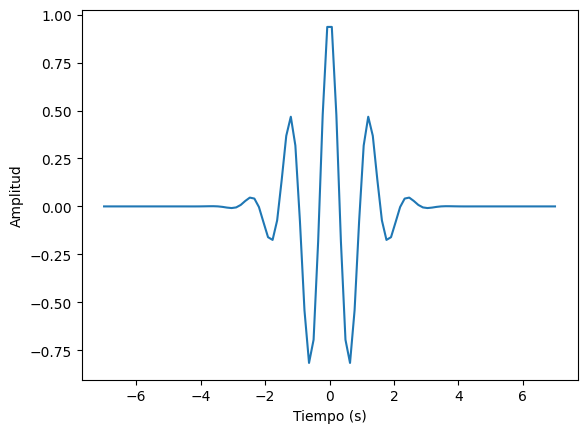

In [1]:
%pylab inline
from scipy import signal
import numpy as np

def morlet(x:ndarray) -> ndarray:
    return np.exp((-x**2)/2) * np.cos(5*x)

t = np.linspace(-7,7,100)
plt.plot(t,morlet(t))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

Otro ejemplo es la ondeleta Haar, cuyo soporte es $[1,-1]$ y es usada para detectar bordes en imágenes por su buena resolución temporal [5,6]. Como regla general, se recomienda escoger una ondeleta que se asemeje a la señal que se quiere analizar, por ejemplo, la ondeleta Morlet se parece a los tonos puros que generamos más adelante. 

# Ondeleta madre

Una _ondeleta madre_ es una ondeleta centrada en cero y que no tiene ningún tipo de escalamiento o desplazamiento. La ondeleta madre es usada para derivar otras ondeletas "hijas" mediante parámetros $a$ y $b$, como sigue:

$$
\psi_{a,b}(t) = \frac{1}{\sqrt{a}}\,\psi\left(\frac{t-b}{a}\right).
$$

por ejemplo, para la ondeleta Morlet que dibujamos arriba, al realizar un escalamiento por $0.5$s y un desplazamiento por $4$s se obtiene la siguiente curva:

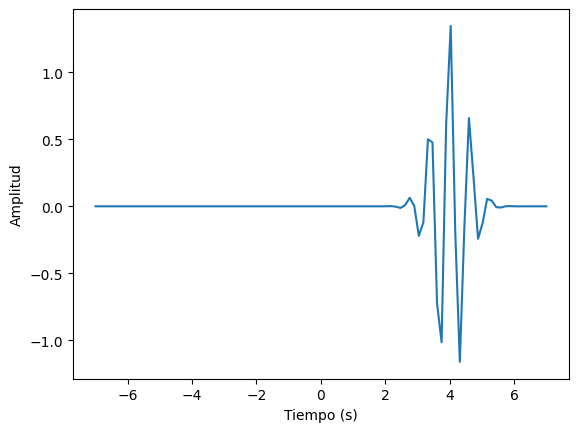

In [2]:
def ondeleta_madre(t:ndarray, a:float, b:float, funcion_ondeleta) -> ndarray:
    return funcion_ondeleta((t-b)/a) * 1.0/np.sqrt(a)

# retrasar 2 segundos y cambiar ancho a la mitad
plt.plot(t,ondeleta_madre(t, a=0.5, b=4, funcion_ondeleta=morlet)) 
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

# Transformada continua de ondeleta

La ondeleta madre permite definir otro concepto llamado _transformada de ondeleta continua_ (CWT, por sus siglas en inglés) que, al igual que la transformada de Fourier, permite obtener coeficientes de análisis. Esto coeficientes indican la correlación entre la función ondeleta (escalada y trasladada por $a$ y $b$) y la función analizada $x$ [2]:

$$
\text{CWT}_f(a,b) = \int_{-\infty}^{\infty}{x(t)\,\psi^{*}_{a,b}(t)dt}.
$$

En la ecuación anterior el operador $\cdot^{*}$ representa el conjugado de un número complejo, es decir, $(a+bi)^{*}=a-bi$ (donde $a,b \in \mathbb{R}$ e $i=\sqrt{-1}$). Abajo vemos un ejemplo de un escalograma definido por la CWT para un tono de frecuencia 100 Hz:

Duracion: 0.050 s


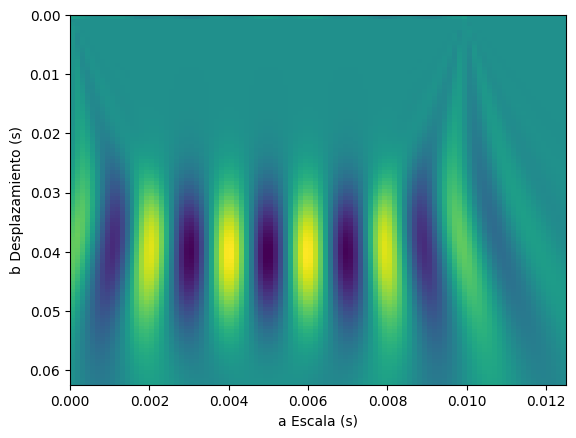

In [3]:
def cwt(f:ndarray, a:float, b:float, ondeleta=morlet) -> ndarray:    
    return np.dot(ondeleta_madre(np.arange(0,len(f)), a, b, ondeleta), f)

F0 = 100 # frec. fundamental (Hz) or 0.001s of period
Fs = 8e3 # frec. muestreo (Hz)
N = int(5*Fs/F0) # mostrar 6 periodos de la senal
T = N/Fs

print('Duracion: %.3f s' % (N/Fs))

n = np.arange(0,N)
y1 = np.cos(2*np.pi*F0/Fs*n) # f=F0/Fs: frecuencia discreta
A = np.linspace(1,100,100)
B = np.linspace(1,500,100)
F = np.zeros([len(A),len(B)])

for iA in range(0,len(A)):
    for iB in range(0,len(B)):
        F[iA,iB] = cwt(y1,A[iA],B[iB])
       
figure()
plt.imshow(F, aspect='auto', extent=[0, A[-1]/Fs, B[-1]/Fs,0]) 
plt.xlabel('a Escala (s)')
plt.ylabel('b Desplazamiento (s)')
show()

El _escalograma_ permite identificar la escala y el desplazamiento experimentado por la ondeleta madre al analizar la señal de entrada y esta información puede traducirse a los conceptos de energía en frecuencias a través del tiempo que ya conocemos del espectrograma (STFT). Por ejemplo, en el escalograma de arriba se aprecia una correlación (o pico de energía) ubicada en $0.008$s, lo cual se aproxima al periodo de $0.01$s ($100$ Hz) de la señal generada. Esto se observa gráficamente como sigue:

NameError: name 'ondeletaMadre' is not defined

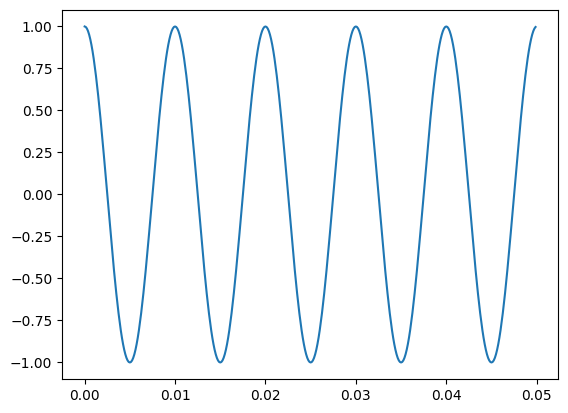

In [4]:
figure()
t=n/Fs
plt.plot(t,y1)
w = ondeletaMadre(t,a=0.008,b=0,ondeletaFunc=morlet)
plt.plot(t,w/max(abs(w)))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
show()

# Transformada discreta de ondeletas

La transformada de ondeletas, al igual que la transformada de Fourier, tiene una versión en tiempo discreto (DTWT, por sus siglas en Inglés) definida como sigue [3,4]:

$$
\text{DTWT}_f[a,b] = \frac{1}{\sqrt{b}} \sum_{m=0}^{p-1}{x[t_m] \, \psi\big[{\frac{t_m-a}{b}}\big]},  
$$

donde:
* $t_m = t(mT_s)$, con $m \in \mathbb{Z}$, es el tiempo discreto muestreado a $T_s \in \mathbb{R}$ segundos,
* $a=K2^{-j}$, con $K \in \mathbb{N}$ (índice de la ondeleta) y $j \in \mathbb{N}$ (índice de escalamiento), es el factor de escala, y
* $b=2^{-j}$ es el factor de desplazamiento.

Como $a$ y $b$ son potencias de dos, se dice que la transformada DTWT es [_diádica_](https://dle.rae.es/d%C3%ADada); esto además define un banco de filtros como el que se muestra abajo:

In [ ]:
def triangulo(x:ndarray) -> ndarray:
    return 1-np.abs(2*x) if np.abs(x)<=0.5 else 0

plt.figure()
time = np.linspace(0,1,500)

for k in range(1,3):
    plt.figure()
    for j in range(0,5):
        b = 2**(-j)
        a = k*b
        print('(%2f,%2f)' % (a,b))
        plt.plot(time,[triangulo((t-a)/b) for t in time])
        plt.xlabel('Tiempo')
        plt.ylabel('Amplitud')
        
    plt.show() 

Este análisis por el banco de filtros está relacionado con la [_propiedad de multiresolución_](https://en.wikipedia.org/wiki/Multiresolution_analysis) (el atractivo principal de la transformada de ondeletas) pues aplicando una ventana de análisis más larga para frecuencia bajas y más corta para frecuencias altas logra atenuar el problema del principio de Incertidumbre de Heisenberg. Este principio afecta a la STFT pues en ella las ventanas de análisis son fijas, y por lo tanto a mayor resolución temporal se obtiene menor resolución frecuencial y viceversa [6]. 

<img src="img/multiresolution.jpg" width="50%"></img>

A nivel computacional, este análisis se visualiza usando una estructura como la siguiente [6]:

<img src="img/bancoFiltros2.png" width="60%"></img>

En el diagrama se observa que la señal $s$ es analizada por un filtro pasa-bajas $L$ para definir el coeficiente de análisis $cA1$, también se observa que el filtro pasa-altas $H$ produce el coeficiente $cD1$. Con un filtro de mayor índice es posible obtener más coeficientes, para ello el filtro $L$ se divide en más filtros pasa-bajas y pasa-altas a modo de cascada. Luego, en la etapa de síntesis, estos coeficientes son procesados por filtros inversos $H'$ y $L'$ para reconstruir la señal $s'$ [6].

Aunque no se abarcan en este notebook, existen otros tipos de transformadas de ondeletas, por ejemplo, la transformada undecimada discreta de ondeletas (UDWT, por sus siglas en inglés), la transformada convencional (o decimada) discreta de ondeletas (DWT, por sus siglas en inglés) y la transformada paquete de ondeletas (PWT, por sus siglas en inglés) [6].

# Librerias existentes

Algunas implementaciones para la CWT y la DTWT se encuentran implementadas en las librerías PyWavelets y Obspy de Python. Abajo se proponen dos ejemplos usando cada librería para calcular los escalogramas del tono puro que construimos anteriormente [7].

## PyWavelets

In [ ]:
from IPython.display import Audio
import time
import pywt
import pywt.data

def pywavelets_cwt(y, Fs, x_range=None, y_range=None):
    (cwtmatr,_) = pywt.cwt(y,np.arange(1,32),'gaus1')
    plt.imshow(cwtmatr, extent=[0, A[-1]/Fs, B[-1]/Fs,0], aspect='auto', # [-1, 1, 1, 63]
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.xlabel('a Escala (s)')
    plt.ylabel('b Desplazamiento (s)')
    if x_range != None:
        plt.xlim(x_range)
    if y_range != None:
        plt.ylim(y_range)
    plt.show()

def benchmark(function, y, Fs, x_range=None, y_range=None):
    start = time.time()
    function(y, Fs, x_range, y_range)
    print('Tiempo transcurrido: %.2fs' % (time.time() - start))
    
benchmark(pywavelets_cwt, y1, Fs)

Vemos que la librería PyWavelet arroja resultados similares a nuestra implementación, donde es necesario interpretar la escala y el desplazamiento para encontrar la frecuencia del tono construido, lo cual nos lleva a seguir buscando otra solución más sencilla.

## Obspy

In [ ]:
import obspy # requires https://visualstudio.microsoft.com/visual-cpp-build-tools/
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

def obspy_cwt(y, Fs, x_range=None, y_range=None):
    scalogram = cwt(st=y, dt=1.0/Fs, w0=32, fmin=0.0001, fmax=Fs/2) # morlet
    ax = plt.figure(2).add_subplot(111)
    t = np.linspace(0,T,len(y))
    x_axis, y_axis = np.meshgrid(t,np.logspace(np.log10(0.0001), np.log10(Fs/2), scalogram.shape[0]))
    ax.pcolormesh(x_axis, y_axis, np.abs(scalogram), cmap=obspy_sequential, shading='auto')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Frecuencia (Hz)')
    if x_range != None:
        plt.xlim(x_range)
    if y_range != None:
        plt.ylim(y_range)
    plt.show()
    
benchmark(obspy_cwt, y1, Fs, None, [0,3*F0])

La librería obspy.signal parece ofrecer lo que andamos buscando: una interpretación más sencilla que expresa el eje de la escala en términos de la pseudofrecuencia y con un tiempo de procesamiento igual de bueno. Cabe mencionar que no analizamos más señales para obtener mejores estimados del tiempo porque nuestro propósito es construir un ejemplo mínimo viable. 

# Transformada wavelet vs. STFT

Ahora analizamos un barrido lineal en frecuencia en el rango de los 20 Hz a 20 kHz para estudiar si la transformada de ondeletas ofrece, en efecto, una mejor resolución temporal-frecuencial:

**Nota: se recomienda bajar el volumen del parlante en este punto pues el barrido puede sonar fuerte para el oído.**

In [ ]:
# construimos un barrido de frecuencias
rango = [20, 20e3] # el rango promedio de audicion humano en Hz
Fs = 44.1 * 1e3 # la tasa de muestreo de los equipos comerciales
T = 1.0 # segundos (t1-t0)
N = int(T*Fs) # s . 1/s
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]
y2 = np.sin(2*np.pi*F0/(2*Fs)*n) # f=F0/Fs: frecuencia discreta
Audio(y2, rate=Fs)

Utilizamos la implementación obspy.signal de la transformada de ondeletas para analizar la señal:

In [ ]:
def benchmark2(function, y, Fs, xRange=None, yRange=None):
    figure()
    benchmark(function, y, Fs)
    figure()
    benchmark(function, y, Fs, xRange, yRange)

benchmark2(obspyCWT, y2, Fs, [0, 0.1], [0,2e3])

Se observa que las frecuencias bajas tienen una resolución más alta que las frecuencias altas, y, al hacer un acercamiento, la resolución de las frecuencias bajas es buena. Ahora aplicamos la STFT:

In [ ]:
def STFT(y,Fs,xRange=None, yRange=None):
    '''
    Tomada de https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
    '''
    f, t, Zxx = signal.stft(y, Fs, nperseg=1000)
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=max(y2), shading='gouraud')
    plt.ylabel('Frecuencia (Hz)')
    plt.xlabel('Tiempo (s)')
    if xRange != None:
        plt.xlim(xRange)
    if yRange != None:
        plt.ylim(yRange)
    plt.show()

benchmark2(STFT, y2, Fs, [0, 0.1], [0,2e3])

Se observa que todas las frecuencias tienen la misma resolución, y, al hacer un acercamiento, la resolución de las frecuencias bajas es mala y borrosa, confirmando la idea de que la transformada de ondeletas funciona como una "lupa" dándole a cada frecuencia la resolución necesaria. Para mejorar la visualización del espectrograma se podría aplicar la raíz cuadrada de la magnitud espectral (lo que logra atenuar las magnitudes bajas y conservar las altas) pero el resultado es igualmente borroso, confirmando que sigue siendo más conveniente usar la transformada de ondeletas. 

In [ ]:
f, t, Zxx = signal.stft(y2, Fs, nperseg=1000)
plt.pcolormesh(t, f, np.sqrt(np.abs(Zxx)), vmin=0, vmax=max(y2), shading='gouraud')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.xlim([0, 0.1])
plt.ylim([0,2e3])
plt.show()

# Conclusiones
Una ondeleta es una función de corta duración que cumple dos condiciones: tener media cero y tener energía finita a lo largo del tiempo. Dos ejemplos de ondeletas son la función Morlet y la ondeleta de Haar. Una ondeleta madre sufre una seria de escalamientos y desplazamiento durante el cálculo de la transformada continua (CWT) y la transformada discreta (DTWT). Ambas transformadas son correlaciones de la función de entrada con un banco de filtros. Esta correlación da lugar a un concepto llamado escalograma, que a diferencia del espectrograma, cumple con el principio de multiresolución, que asigna a cada frecuencia una ventana de análisis diferenciada. En el caso de la DTWT, el banco de filtros sigue una distribución diádica (en potencias de dos), y a nivel computacional los filtros están dispuestos en forma de cascada, lo que significa que la porción de la señal filtrada por el filtro pasabajas es descompuesta recursivamente. Python ofrece dos formas de calcular la CWT a través de las librerías PyWavelet y Obspy, ambas presentan tiempo similares de procesamiento con la única señal empleada.

# Referencias

1. Wikipedia contributors. (2021, February 17). Mexican hat wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 00:05, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Mexican_hat_wavelet&oldid=1007284050

2. M. Vetterli, J. Kovacevic. Wavelets and Subband Coding. Orignally published in 1995 by Prentice Hall PTR, Englewood Cliffs, New Jersey. Reissued by authors in 2007.

3. Wikipedia contributors. (2021, March 3). Correlation and dependence. In Wikipedia, The Free Encyclopedia. Retrieved 00:47, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Correlation_and_dependence&oldid=1010073167

4. Andrew Nicoll. The Wavelet Transform for Beginners. URL: https://youtu.be/kuuUaqAjeoA (consultado por última vez el 05/22/21)

5. Wikipedia contributors. (2021, March 25). Haar wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 03:43, May 27, 2021, from https://en.wikipedia.org/w/index.php?title=Haar_wavelet&oldid=1014128738\

6. D. Lee Fugal. Conceptual Wavelets, in digital signal processing. Space and signals technical publishing. 2009. ISBN 978-0-9821994-5-9.

7. PyWavelets Documentation. Continuous Wavelet Transform (CWT). URL: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html (consultado por última vez el 06/26/25)

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2021,
  author = {Juan M. Fonseca-Solís},
  title = {Desmistificando la transformada de ondeletas},
  year = 2021,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.wavelets.html},
  urldate = {}
}
```